In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
from mpi4py import MPI
import pickle


# torch
from torch.nn.parameter import Parameter
import torch
import torch.nn as nn
torch.autograd.set_detect_anomaly(False)

# quimb
import quimb as qu
import quimb.tensor as qtn
import autoray as ar
from autoray import do

# from vmc_torch.experiment.tn_model import *
from vmc_torch.sampler import MetropolisExchangeSamplerSpinful
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import SGD, SignedSGD, SignedRandomSGD, SR, TrivialPreconditioner, Adam, SGD_momentum, DecayScheduler
from vmc_torch.VMC import VMC
# from vmc_torch.hamiltonian import spinful_Fermi_Hubbard_square_lattice
from vmc_torch.hamiltonian_torch import spinful_Fermi_Hubbard_square_lattice_torch
from vmc_torch.torch_utils import SVD,QR
from vmc_torch.fermion_utils import generate_random_fpeps
from vmc_torch.utils import closest_divisible

# # Register safe SVD and QR functions to torch
# ar.register_function('torch','linalg.svd',SVD.apply)
# ar.register_function('torch','linalg.qr',QR.apply)

from vmc_torch.global_var import DEBUG


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
Lx = int(4)
Ly = int(4)
symmetry = 'Z2'
t = 1.0
U = 8.0
N_f = int(Lx*Ly-2)
# N_f=12
n_fermions_per_spin = (N_f//2, N_f//2)
H = spinful_Fermi_Hubbard_square_lattice_torch(Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
graph = H.graph
# TN parameters
D = 4
chi = 16
dtype=torch.float64

# Load PEPS
try:
    skeleton = pickle.load(open(f"../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl", "rb"))
    peps_params = pickle.load(open(f"../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl", "rb"))
    peps = qtn.unpack(peps_params, skeleton)
except:
    peps = generate_random_fpeps(Lx, Ly, D=D, seed=2, symmetry=symmetry, Nf=N_f, spinless=False)[0]
peps_np = peps.copy()
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype))
for ts in peps.tensors:
    ts.data.phase_sync(inplace=True)

# VMC sample size
N_samples = 2
N_samples = closest_divisible(N_samples, SIZE)

from fermion_compress import *

In [2]:
# random_x = torch.tensor(H.hilbert.random_state())
random_x = torch.tensor([0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0])
print("random_x:", random_x)

random_x: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [3]:
amp0 = peps.get_amp(random_x)
for ts in amp0.tensors:
    ts.data.phase_sync(inplace=True)
amp1 = amp0.contract_boundary_from_xmin(xrange=(0, 1), max_bond=16, cutoff=0.0, mode='zipup', sweep_reverse=False)
amp1.contract(), amp0.contract()

(tensor(4487.1521, dtype=torch.float64),
 tensor(4487.1521, dtype=torch.float64))

In [4]:
row_no = 2
amp_fit = amp0.contract_boundary_from_xmin(xrange=(0, row_no), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=1)
print(amp_fit.contract())
paritymap = {0:0, 1:1, 2:1, 3:0}
parity_2rows = sum([paritymap[i] for i in random_x[:Ly*2].tolist()]) % 2
print("parity_2rows:", parity_2rows)

tensor(4487.1521, dtype=torch.float64)
parity_2rows: 0


In [5]:
row_no = 2
amp_fit = amp0.contract_boundary_from_xmin(xrange=(0, row_no), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=2)
print(amp_fit.contract())
paritymap = {0:0, 1:1, 2:1, 3:0}
parity_2rows = sum([paritymap[i] for i in random_x[:Ly*2].tolist()]) % 2
print("parity_2rows:", parity_2rows)

tensor(4487.1521, dtype=torch.float64)
parity_2rows: 0


In [16]:
row_no = 2
amp_fit = amp0.contract_boundary_from_xmax(xrange=(row_no, Lx-1), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=2)
print(amp_fit.contract())
paritymap = {0:0, 1:1, 2:1, 3:0}
parity_2rows = sum([paritymap[i] for i in random_x[:Ly*2].tolist()]) % 2
print("parity_2rows:", parity_2rows)

tensor(-17649.6791, dtype=torch.float64)
parity_2rows: 0


Contracting I2,0 with I3,0
Contracting I2,1 with I3,1
Contracting I2,2 with I3,2
Contracting I2,3 with I3,3


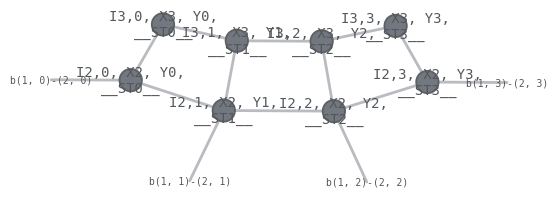

max_tdiff=1.74e+00: 100%|##########| 2/2 [00:00<00:00, 52.72it/s]

duals of env legs: left None right 2
None True
duals of env legs: left 0 right 3
False True
duals of env legs: left 0 right None
False None
duals of env legs: left 0 right None
False None
duals of env legs: left 0 right 3
False True
duals of env legs: left None right 2
None True

compressed_amp: tensor(4487.1521, dtype=torch.float64)
infidelity: tensor(0., dtype=torch.float64)


In [9]:
record = {}
site_tag_tmps = ['__ST0__', '__ST1__', '__ST2__', '__ST3__']
for j, st in zip(range(Ly), site_tag_tmps):
    tag1 = amp0.site_tag(2, j)
    tag2 = amp0.site_tag(3, j)
    print(f"Contracting {tag1} with {tag2}")
    amp0.add_tag(
        st, where=(tag1, tag2), which="any", record=record
    )

tn_rest_1, tn_boundary = amp0.partition(site_tag_tmps, inplace=False)
tn_boundary.draw()

new_tn_boundary = tensor_network_1d_compress_fit_fermion(
    tn_boundary,
    max_bond=16,
    cutoff=0.0,
    site_tags=site_tag_tmps,
    tn_fit='zipup',
    bsz=2,
    inplace=False,
    max_iterations=2,
    progbar=True
)

tn_rest = tn_rest_1.copy()

tn_rest.add_tensor_network(new_tn_boundary, virtual=True)
print("\ncompressed_amp:", tn_rest.contract())
print('infidelity:', new_tn_boundary.distance(tn_boundary, normalized='infidelity'))

# new_tn_boundary['I0,3'].data.phase_flip(1, inplace=True), new_tn_boundary['I0,2'].data.phase_flip(1, inplace=True)
# print(new_tn_boundary.distance(tn_boundary, normalized='infidelity'))

In [10]:
amp_fit.select(['X2', 'X3']).distance(new_tn_boundary, normalized='infidelity')

tensor(0.8586, dtype=torch.float64)

In [13]:
(tn_rest_1|new_tn_boundary).contract(), (tn_rest_1|amp_fit.select(['X2', 'X3'])).contract()

(tensor(4487.1521, dtype=torch.float64),
 tensor(-17649.6791, dtype=torch.float64))

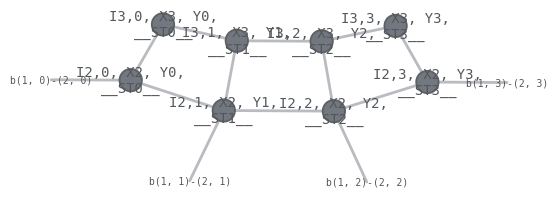

In [57]:
tn_boundary.draw()

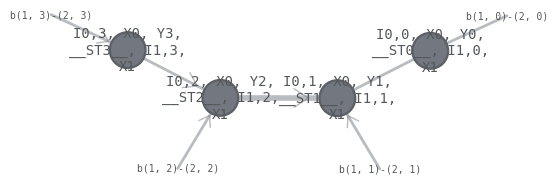

(None, tensor(192699.5354, dtype=torch.float64))

In [35]:
new_tn_boundary.draw(), (new_tn_boundary|new_tn_boundary.conj()).contract()

In [39]:
ts1 = new_tn_boundary['I0,3']
ts1_array = ts1.contract().data
# ts1_array._charge = 0
# ts1_array._oddpos = {}
# when considering the global oddpos, there should be an extra minus sign
ts1_array.phase_sync(inplace=True)
ts1_array_conj = ts1_array.conj()
for i in range(len(ts1_array_conj.duals)):
    if not ts1_array_conj.duals[i]:
        ts1_array_conj.phase_flip(i, inplace=True)

print(ts1_array.norm()**2)
do('tensordot', ts1_array, ts1_array_conj)

tensor(1233038.9811, dtype=torch.float64)


tensor(1233038.9811, dtype=torch.float64)

In [41]:
new_tn_boundary_ts, row1_zipup_ts = new_tn_boundary.contract(), row1_zipup.contract()
new_tn_boundary_ts.data.phase_sync(inplace=True)
row1_zipup_ts.data.phase_sync(inplace=True)

for sec, ts in new_tn_boundary_ts.data.blocks.items():
    print(sec, ts, row1_zipup_ts.data.blocks[sec])

(0, 0, 0, 1) tensor([[[[  -6.9909,  -52.4583],
          [ -17.3306,   17.2355]],

         [[  22.0381,  -86.7774],
          [  20.2419,    2.2315]]],


        [[[ -22.1438,  116.4294],
          [   3.5687,   -4.5299]],

         [[-248.1538,  255.7077],
          [  92.7239,   72.1634]]]], dtype=torch.float64) tensor([[[[   6.9909,   52.4583],
          [  17.3306,  -17.2355]],

         [[ -22.0381,   86.7774],
          [ -20.2419,   -2.2315]]],


        [[[  22.1438, -116.4294],
          [  -3.5687,    4.5299]],

         [[ 248.1538, -255.7077],
          [ -92.7239,  -72.1634]]]], dtype=torch.float64)
(1, 0, 1, 1) tensor([[[[-12.4329,  12.0782],
          [  7.0025, -16.6213]],

         [[-13.0030,  -3.5713],
          [ -5.1327,   0.3961]]],


        [[[-45.2798,  43.7444],
          [ 33.3535,   9.2165]],

         [[-21.7941,  19.2332],
          [ 37.5919, -63.8209]]]], dtype=torch.float64) tensor([[[[ 12.4329, -12.0782],
          [ -7.0025,  16.6213]],

         [[ 

In [25]:
new_tn_boundary_ts.data.duals

(False, False, False, False)

In [26]:
new_tn_boundary_ts.inds

('b(1, 3)-(2, 3)', 'b(1, 2)-(2, 2)', 'b(1, 1)-(2, 1)', 'b(1, 0)-(2, 0)')

In [27]:
row1_zipup_ts

Tensor(shape=(4, 4, 4, 4), inds=('b(1, 3)-(2, 3)', 'b(1, 2)-(2, 2)', 'b(1, 1)-(2, 1)', 'b(1, 0)-(2, 0)'), tags=oset(['I0,3', 'X0', 'Y3', 'I1,3', 'X1', 'I0,2', 'Y2', 'I1,2', 'I0,1', 'Y1', 'I1,1', 'I0,0', 'Y0', 'I1,0']))